# Test 1: Spectered Embeddings Baseline + Behavioral Audit (Local W2V and HistWords SGNS)

This notebook reproduces the core “spectered embeddings” idea on two corpora (my small domain corpus of plantation literature fiction adjacent works, which are 164 texts from 1834 to 1912 and HistWords SGNS) and audits on the method. The goal is to generate spectered vectors and to check whether spectering improves stability, reduces decade-to-decade noise, or instead produced better representations of embeddings and word drift. 

What this test delivers:

A working baseline pipeline: load embeddings, align across decades, generate spectered variants.

Behavioral analysis: neighbor stability across decades, sensitivity to weighting choices, and coverage checks.

Clear identification of baseline gaps and failure modes to motivate later variants.

Outputs:

Printed tables and plots for neighbor sets and stability metrics (no files saved by default).

A minimal set of parameters at the top to rerun on new term lists.


In [6]:
# If you run this in a fresh environment, uncomment:
# %pip install -q numpy pandas matplotlib scipy gensim tqdm


In [7]:
from pathlib import Path
import re, glob, pickle
from typing import Dict, List, Tuple, Optional, Callable, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes
from gensim.models import KeyedVectors

pd.set_option("display.max_colwidth", 180)


## 0) Config 

In [8]:
# -----------------------------
# Paths
# -----------------------------
THESIS_ROOT = Path(r"G:/My Drive/ThesisMaterial")
LOCAL_W2V_DIR = THESIS_ROOT / "Computation" / "models" / "word2vecDecade"
SGNS_DIR      = THESIS_ROOT / "Computation" / "data" / "sgns"

# -----------------------------
# Token cleaning (neighbor display + anchor selection)
# Tweak these if your corpus has different tokenization.
# -----------------------------
TOKEN_MIN_LEN = 3

# Drop digits, roman numerals, and heavy punctuation/noise.
RE_ROMAN = re.compile(r"^[ivxlcdm]+$", re.IGNORECASE)
RE_HAS_DIGIT = re.compile(r"\d")
RE_BAD_PUNCT = re.compile(r"[^a-zA-Z\-']")   # allow letters, hyphen, apostrophe
RE_MULTI_HYPHEN = re.compile(r"-{2,}")

def is_good_token(w: str) -> bool:
    if w is None:
        return False
    w = w.strip()
    if len(w) < TOKEN_MIN_LEN:
        return False
    if RE_HAS_DIGIT.search(w):
        return False
    if RE_ROMAN.match(w):
        return False
    if RE_MULTI_HYPHEN.search(w):
        return False
    # reject tokens with characters outside [A-Za-z-']
    if RE_BAD_PUNCT.search(w):
        return False
    # avoid leading/trailing hyphen
    if w.startswith("-") or w.endswith("-"):
        return False
    return True

# -----------------------------
# Experiment term sets (edit freely)
# -----------------------------
TERM_SETS = {
    "sanity_common": ["man","woman","child","house","room","work","money","horse"],
    "plantation_core": ["plantation","slave","master","cotton"],
    "your_current": ["freedom","master","slave","cotton","negro"],
}

ACTIVE_TERM_SET = "your_current"   # <--- change this
TARGET_WORDS = TERM_SETS[ACTIVE_TERM_SET]

# -----------------------------
# Specter parameters (edit)
# -----------------------------
WEIGHTING_SCHEME = "exponential_decay"  # exponential_decay | uniform | recency_bias
ALPHA = 0.7
MIN_WEIGHT = 0.05

# -----------------------------
# Alignment parameters (edit)
# -----------------------------
N_ANCHORS = 2000         # key change: use a big anchor set
ANCHOR_RANDOM_SEED = 7


## 1) Loaders + alignment 

In [9]:
def normalize_rows(W: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    W = W.astype(np.float32, copy=False)
    norms = np.linalg.norm(W, axis=1, keepdims=True)
    norms = np.maximum(norms, eps)
    return W / norms

def list_local_w2v_buckets(local_dir: Path) -> List[int]:
    if not local_dir.exists():
        return []
    decades = []
    for p in local_dir.glob("word2vec_*.w2v"):
        m = re.search(r"word2vec_(\d{4})_(\d{4})\.w2v$", p.name)
        if m:
            decades.append(int(m.group(1)))
    return sorted(set(decades))

def load_local_w2v_decade(decade: int, local_dir: Path) -> Tuple[np.ndarray, List[str], Dict[str,int]]:
    candidates = sorted(local_dir.glob(f"word2vec_{decade}_*.w2v"))
    if not candidates:
        raise FileNotFoundError(f"No .w2v found for decade start {decade} in {local_dir}")
    kv = KeyedVectors.load_word2vec_format(str(candidates[0]), binary=False)
    vocab = list(kv.index_to_key)
    W = normalize_rows(kv.vectors)
    w2i = {w:i for i,w in enumerate(vocab)}
    return W, vocab, w2i

def _find_file_for_decade(directory: Path, decade: int, exts: Tuple[str,...]) -> Optional[Path]:
    pats = [str(directory / f"*{decade}*{ext}") for ext in exts]
    hits = []
    for pat in pats:
        hits.extend([Path(p) for p in glob.glob(pat)])
    hits = sorted(hits, key=lambda p: (len(p.name), p.name))
    return hits[0] if hits else None

def list_sgns_decades(sgns_dir: Path) -> List[int]:
    if not sgns_dir.exists():
        return []
    decades = set()
    for p in sgns_dir.glob("*.npy"):
        m = re.search(r"(\d{4})", p.name)
        if m:
            y = int(m.group(1))
            if y % 10 == 0:
                decades.add(y)
    return sorted(decades)

def load_sgns_decade(decade: int, sgns_dir: Path) -> Tuple[np.ndarray, List[str], Dict[str,int]]:
    w_path = _find_file_for_decade(sgns_dir, decade, (".npy",))
    v_path = _find_file_for_decade(sgns_dir, decade, (".pkl", ".pickle"))
    if w_path is None or v_path is None:
        raise FileNotFoundError(f"Missing SGNS files for {decade} in {sgns_dir} (need .npy + vocab .pkl)")
    W = normalize_rows(np.load(str(w_path)))
    with open(v_path, "rb") as f:
        vocab = list(pickle.load(f))
    if len(vocab) != W.shape[0]:
        raise ValueError(f"{decade}: vocab length {len(vocab)} != W rows {W.shape[0]} for {w_path.name}")
    w2i = {w:i for i,w in enumerate(vocab)}
    return W, vocab, w2i

def build_alignment(load_fn: Callable[[int], Tuple[np.ndarray, List[str], Dict[str,int]]],
                    decades: List[int],
                    ref_decade: int,
                    stable_words: List[str]) -> Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]:
    """Align every decade to ref_decade via orthogonal Procrustes on shared stable anchors."""
    W_ref, vocab_ref, w2i_ref = load_fn(ref_decade)
    anchors = [w for w in stable_words if w in w2i_ref]
    if len(anchors) < 8:
        raise RuntimeError(f"Too few anchors present in reference decade {ref_decade}: {len(anchors)}")

    aligned = {}
    for d in decades:
        W, vocab, w2i = load_fn(d)
        shared = [w for w in anchors if w in w2i]
        if len(shared) < 8:
            continue

        idx_d   = np.array([w2i[w] for w in shared], dtype=int)
        idx_ref = np.array([w2i_ref[w] for w in shared], dtype=int)

        A_d   = W[idx_d]
        A_ref = W_ref[idx_ref]

        R, _ = orthogonal_procrustes(A_d, A_ref)
        W_aligned = normalize_rows(W @ R)

        aligned[d] = (W_aligned, vocab, w2i)
    return aligned


## 2) Strong anchor selection

Fix for unstable alignment issues 

In [10]:
def build_large_intersection_anchors(
    load_fn: Callable[[int], Tuple[np.ndarray, List[str], Dict[str,int]]],
    decades: List[int],
    ref_decade: int,
    n_anchors: int = 2000,
    seed: int = 7,
) -> List[str]:
    """
    Build a large anchor list by taking the intersection vocab across all decades,
    cleaning tokens, then sampling up to n_anchors.
    """
    _, vocab_ref, _ = load_fn(ref_decade)
    inter: Set[str] = set([w for w in vocab_ref if is_good_token(w)])

    for d in decades:
        _, vocab, _ = load_fn(d)
        inter &= set([w for w in vocab if is_good_token(w)])
        if len(inter) == 0:
            break

    inter = sorted(inter)
    if not inter:
        raise RuntimeError("Intersection anchors are empty after cleaning. Relax is_good_token() or TOKEN_MIN_LEN.")

    rng = np.random.default_rng(seed)
    if len(inter) > n_anchors:
        idx = rng.choice(len(inter), size=n_anchors, replace=False)
        anchors = [inter[i] for i in idx]
    else:
        anchors = inter

    return anchors

def describe_vocab_noise(vocab: List[str], n: int = 30) -> pd.DataFrame:
    samp = vocab[: min(len(vocab), 5000)]
    good = [w for w in samp if is_good_token(w)]
    bad = [w for w in samp if not is_good_token(w)]
    return pd.DataFrame({
        "sample_size": [len(samp)],
        "good_tokens": [len(good)],
        "bad_tokens": [len(bad)],
        "bad_rate": [len(bad) / max(1, len(samp))],
        "example_bad": [", ".join(bad[:n])]
    })


## 3) Discover decades + build aligned baselines

In [11]:
local_decades = list_local_w2v_buckets(LOCAL_W2V_DIR)
sgns_decades  = list_sgns_decades(SGNS_DIR)

COMMON_DECADES = sorted(set(local_decades) & set(sgns_decades))
if not COMMON_DECADES:
    raise RuntimeError("No overlapping decades found between LOCAL_W2V_DIR and SGNS_DIR.")

REF_DECADE = COMMON_DECADES[-1]

print("COMMON_DECADES:", COMMON_DECADES)
print("REF_DECADE:", REF_DECADE)

def load_local(d: int):
    return load_local_w2v_decade(d, LOCAL_W2V_DIR)

def load_sgns(d: int):
    return load_sgns_decade(d, SGNS_DIR)

# Quick noise check
_, vocab_local_ref, _ = load_local(REF_DECADE)
_, vocab_sgns_ref,  _ = load_sgns(REF_DECADE)
display(describe_vocab_noise(vocab_local_ref))
display(describe_vocab_noise(vocab_sgns_ref))

# Build big anchors separately per embedding family
anchors_local = build_large_intersection_anchors(load_local, COMMON_DECADES, REF_DECADE, n_anchors=N_ANCHORS, seed=ANCHOR_RANDOM_SEED)
anchors_sgns  = build_large_intersection_anchors(load_sgns,  COMMON_DECADES, REF_DECADE, n_anchors=N_ANCHORS, seed=ANCHOR_RANDOM_SEED)

print("anchors_local:", len(anchors_local))
print("anchors_sgns :", len(anchors_sgns))

# Align
w2v_aligned  = build_alignment(load_local, COMMON_DECADES, REF_DECADE, anchors_local)
sgns_aligned = build_alignment(load_sgns,  COMMON_DECADES, REF_DECADE, anchors_sgns)

print("Aligned W2V decades:", sorted(w2v_aligned.keys()))
print("Aligned SGNS decades:", sorted(sgns_aligned.keys()))


COMMON_DECADES: [1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]
REF_DECADE: 1900


,sample_size,good_tokens,bad_tokens,bad_rate,example_bad
0,5000,4851,149,0.0298,"to, of, a, he, i, in, it, as, an, on, at, is, be, de, me, by, do, my, so, no, up, if, did, we, or, go, er, oh, o, am"


,sample_size,good_tokens,bad_tokens,bad_rate,example_bad
0,5000,4878,122,0.0244,"of, to, in, a, is, it, be, as, he, i, by, on, at, or, we, an, so, if, no, my, do, me, up, did, us, go, am, 1, de, 2"


anchors_local: 2000
anchors_sgns : 2000
Aligned W2V decades: [1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]
Aligned SGNS decades: [1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900]


## 4) Alignment stability check

In [12]:
def anchor_alignment_report(aligned: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                            ref_decade: int,
                            anchors: List[str]) -> pd.DataFrame:
    W_ref, _, w2i_ref = aligned[ref_decade]
    rows = []
    for d,(W,_,w2i) in sorted(aligned.items()):
        shared = [w for w in anchors if (w in w2i and w in w2i_ref)]
        if len(shared) < 200:
            continue
        idx_d = np.array([w2i[w] for w in shared], dtype=int)
        idx_r = np.array([w2i_ref[w] for w in shared], dtype=int)
        sims = np.sum(W[idx_d] * W_ref[idx_r], axis=1)
        rows.append({
            "decade": d,
            "n_shared": len(shared),
            "anchor_cos_mean_to_ref": float(np.mean(sims)),
            "anchor_cos_std_to_ref": float(np.std(sims)),
            "anchor_cos_p10_to_ref": float(np.quantile(sims, 0.10)),
            "anchor_cos_p90_to_ref": float(np.quantile(sims, 0.90)),
        })
    return pd.DataFrame(rows)

display(anchor_alignment_report(w2v_aligned,  REF_DECADE, anchors_local))
display(anchor_alignment_report(sgns_aligned, REF_DECADE, anchors_sgns))


,decade,n_shared,anchor_cos_mean_to_ref,anchor_cos_std_to_ref,anchor_cos_p10_to_ref,anchor_cos_p90_to_ref
0,1830,2000,0.606885,1.034245e-01,0.487887,0.751502
1,1840,2000,0.613802,1.085239e-01,0.489306,0.764629
2,1850,2000,0.567626,8.574303e-02,0.470970,0.672761
3,1860,2000,0.576145,8.594336e-02,0.476999,0.686406
4,1870,2000,0.600416,1.016380e-01,0.486720,0.735444
5,1880,2000,0.583735,9.393584e-02,0.474564,0.705985
6,1890,2000,0.571355,9.200789e-02,0.468589,0.692759
7,1900,2000,1.000000,8.354224e-08,1.000000,1.000000


,decade,n_shared,anchor_cos_mean_to_ref,anchor_cos_std_to_ref,anchor_cos_p10_to_ref,anchor_cos_p90_to_ref
0,1830,2000,0.163574,0.314456,0.0,0.773718
1,1840,2000,0.177712,0.320434,0.0,0.764580
2,1850,2000,0.208218,0.327360,0.0,0.745351
3,1860,2000,0.195892,0.326441,0.0,0.758491
4,1870,2000,0.210976,0.330599,0.0,0.751614
5,1880,2000,0.240943,0.337123,0.0,0.745911
6,1890,2000,0.259970,0.337858,0.0,0.744133
7,1900,2000,0.425500,0.494419,0.0,1.000000


## 5) Spectered embeddings 

In [13]:
def load_spectered_from_aligned(
    aligned: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
    decades_ordered: List[int],
    weighting_scheme: str = "exponential_decay",
    alpha: float = 0.7,
    min_weight: float = 0.05,
) -> Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]:
    decades_ordered = [d for d in decades_ordered if d in aligned]
    if not decades_ordered:
        raise RuntimeError("No decades available in aligned dict for spectering.")

    spectered = {}
    for i, cur_dec in enumerate(decades_ordered):
        W_cur, vocab_cur, w2i_cur = aligned[cur_dec]
        W_spec = np.zeros_like(W_cur)

        if weighting_scheme == "recency_bias":
            denom = (i + 1) * (i + 2) / 2.0

        for word in vocab_cur:
            idx_cur = w2i_cur[word]
            past_vecs = []
            past_wts = []

            for j in range(i + 1):
                past_dec = decades_ordered[j]
                W_p, _, w2i_p = aligned[past_dec]
                if word not in w2i_p:
                    continue

                steps_back = i - j
                if weighting_scheme == "exponential_decay":
                    wt = alpha ** steps_back
                elif weighting_scheme == "uniform":
                    wt = 1.0
                elif weighting_scheme == "recency_bias":
                    wt = (j + 1) / denom
                else:
                    raise ValueError(f"Unknown weighting_scheme: {weighting_scheme}")

                if wt < min_weight:
                    continue

                past_vecs.append(W_p[w2i_p[word]])
                past_wts.append(wt)

            if past_vecs:
                wts = np.array(past_wts, dtype=np.float32)
                wts /= wts.sum()
                W_spec[idx_cur] = np.average(np.vstack(past_vecs), axis=0, weights=wts)
            else:
                W_spec[idx_cur] = W_cur[idx_cur]

        spectered[cur_dec] = (normalize_rows(W_spec), vocab_cur, w2i_cur)

    return spectered

DECADES_ORDERED = sorted(w2v_aligned.keys())

w2v_spectered = load_spectered_from_aligned(
    w2v_aligned, DECADES_ORDERED,
    weighting_scheme=WEIGHTING_SCHEME, alpha=ALPHA, min_weight=MIN_WEIGHT
)
sgns_spectered = load_spectered_from_aligned(
    sgns_aligned, DECADES_ORDERED,
    weighting_scheme=WEIGHTING_SCHEME, alpha=ALPHA, min_weight=MIN_WEIGHT
)

print("TARGET_WORDS:", TARGET_WORDS)
print("Specter params:", WEIGHTING_SCHEME, "alpha=", ALPHA, "min_weight=", MIN_WEIGHT)


TARGET_WORDS: ['freedom', 'master', 'slave', 'cotton', 'negro']
Specter params: exponential_decay alpha= 0.7 min_weight= 0.05


## 6) Evaluation utilities 

In [14]:
def topk_neighbors(W: np.ndarray, vocab: List[str], w2i: Dict[str,int], term: str, k: int = 25) -> List[Tuple[str, float]]:
    if term not in w2i:
        return []
    i = w2i[term]
    v = W[i]
    sims = W @ v
    sims[i] = -np.inf
    idx = np.argpartition(sims, -k)[-k:]
    idx = idx[np.argsort(-sims[idx])]
    return [(vocab[j], float(sims[j])) for j in idx]

def clean_neighbors(neigh: List[Tuple[str, float]], keep_k: int = 12) -> List[Tuple[str, float]]:
    out = []
    for w,s in neigh:
        if is_good_token(w):
            out.append((w,s))
        if len(out) >= keep_k:
            break
    return out

def neighbor_trail(term: str,
                   emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                   k: int = 75,
                   keep_k: int = 12) -> pd.DataFrame:
    rows = []
    for d,(W,vocab,w2i) in sorted(emb.items()):
        nbs = clean_neighbors(topk_neighbors(W, vocab, w2i, term, k=k), keep_k=keep_k)
        rows.append({"decade": d, "neighbors": ", ".join([w for w,_ in nbs])})
    return pd.DataFrame(rows)

def neighbor_overlap(term: str,
                     emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]],
                     k: int = 100,
                     keep_k: int = 25) -> pd.DataFrame:
    decades = sorted(emb.keys())
    prev_set = None
    prev_dec = None
    rows = []
    for d in decades:
        W,vocab,w2i = emb[d]
        nbs = clean_neighbors(topk_neighbors(W, vocab, w2i, term, k=k), keep_k=keep_k)
        cur_set = set([w for w,_ in nbs])
        if prev_set is not None:
            inter = len(cur_set & prev_set)
            union = len(cur_set | prev_set) or 1
            rows.append({"decade": d, "prev_decade": prev_dec, "jaccard": inter/union})
        prev_set, prev_dec = cur_set, d
    return pd.DataFrame(rows)

def adjacent_change(term: str, emb: Dict[int, Tuple[np.ndarray, List[str], Dict[str,int]]]) -> pd.DataFrame:
    decades = sorted(emb.keys())
    rows = []
    prev_vec = None
    prev_dec = None
    for d in decades:
        W, _, w2i = emb[d]
        if term not in w2i:
            prev_vec, prev_dec = None, None
            continue
        v = W[w2i[term]]
        if prev_vec is not None:
            cos = float(v @ prev_vec)
            rows.append({"decade": d, "prev_decade": prev_dec, "cos_to_prev": cos, "change": 1.0 - cos})
        prev_vec, prev_dec = v, d
    return pd.DataFrame(rows)

def plot_two_series(df_a: pd.DataFrame, df_b: pd.DataFrame, x: str, y: str, label_a: str, label_b: str, title: str):
    plt.figure()
    if not df_a.empty:
        plt.plot(df_a[x], df_a[y], marker="o", label=label_a)
    if not df_b.empty:
        plt.plot(df_b[x], df_b[y], marker="o", label=label_b)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()


## 7) Run: neighbors + overlap + drift for your active term set


TERM: freedom

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"stares, democracy, incendiary, venus, slaveholders, assistant, abolitionist, dual, insisting, oxen, contingency, handmaid"
1,1840,"thick-set, trysting-places, grandest, mart, deceptive, oppression, wearied, tyrants, yoke, ban, hissed, strand"
2,1850,"sober-minded, signet, field-laborer, trickery, bad-looking, hollar, assassinated, jural, plantashun, yov, strictness, discountenanced"
3,1860,"tyrannously, dom, leadenhall, man-servant, reflectively, appro, inspires, initiatively, theorists, pocketing, bothered, bined"
4,1870,"self-awakened, beneficence, sympathise, pro-slavery, beneficial, reversing, shackled, defect, proportionably, spicion, environs, fection"
5,1880,"niek, realizes, harborin, trample, arly, gibus, secede, remedies, ported, oncet, sovereignty, estimated"
6,1890,"simian, coquetr, bigotries, avagons, onybody, dowu, worthlessness, cerements, brunt, dinner-bugle, barbarisms, girding"
7,1900,"rosemary, plantain, deuced, splease, fathomed, freer, yerbs, spah, reptile, hog-feeder, minnows, indecency"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"stares, democracy, incendiary, venus, slaveholders, assistant, abolitionist, dual, insisting, oxen, contingency, handmaid"
1,1840,"degradation, tyrants, oppression, inculcated, rooted, inquietude, thick-set, trysting-places, passive, hazarded, usurped, grandest"
2,1850,"inquietude, overthrow, slaveholding, emufa, tyrannize, ishmael, chargeable, slave-dealer, whereas, retard, galling, hazarded"
3,1860,"accruing, man-servant, escutcheon, emancipating, enslaved, vilify, calamities, slaveholder, perdition, determines, riots, down-trodden"
4,1870,"tyrants, slaveholder, pro-slavery, aro, fellow-beings, self-awakened, liberation, proportionably, well-meant, equality, slave-holding, liber"
5,1880,"liberation, fanatics, secede, arrogance, slaveholder, redress, governmental, equality, regeneration, gomorrah, politic, rhodomontades"
6,1890,"simian, sophistries, scoundrels, liberation, slaveholder, onybody, healthily, obloquy, murdering, repudiate, school-houses, forfeited"
7,1900,"ste, spah, deuced, cross-questioned, performs, debarred, stoned, slaveholders, treasonable, disrespect, councils, practices"


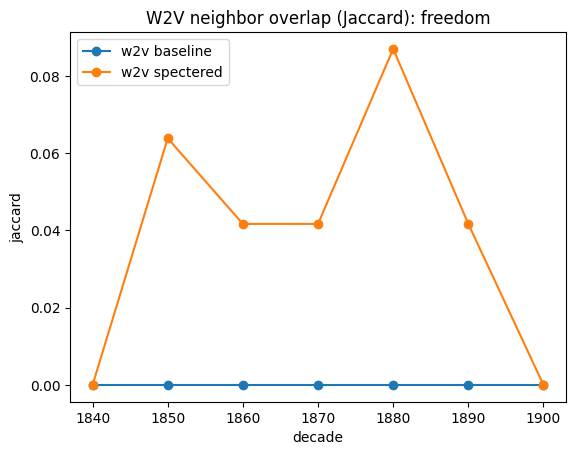

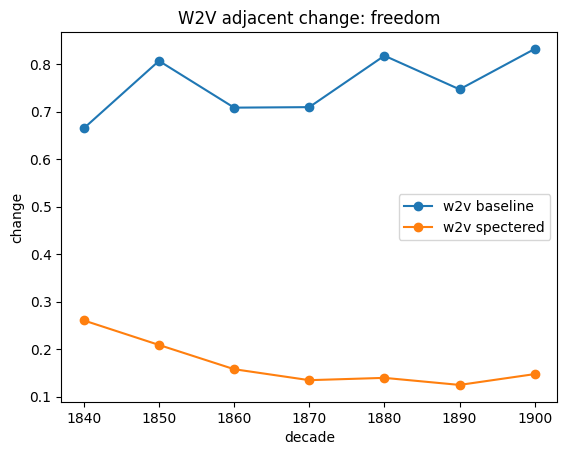


TERM: master

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"prophecy, ifke, brisker, wilh, inslance, incoherence, junol, alf, grimace, prerogatives, reclaimed, fellow-countrymen"
1,1840,"kidnapped, hardness, whippings, inarticulate, self-defence, unfeeling, tasks, insubordination, enhance, resource, poplar-grove, injuries"
2,1850,"slackening, rosined, lappel, curis, honeycomb, halloed, impas, smel, larned, ironical, baltimo, spcakin"
3,1860,"fence-post, iliggs, suddant, pendence, ancesters, bugbear, horse-killers, lives-all, wlion, whimpering, bob-tailed, sriore"
4,1870,"promonitaries, worker, gesticulative, mothing, forgbt, schoonermen, devoutest, spout, tax, bag-pipe, jackace, cringing"
5,1880,"cnsbiche, bouncing, deep-rooted, redolence, bastets, canons, scholah, foreknowledge, rubserved, correspondingly, desecrate, to-mo"
6,1890,"barbecued, merrimac, unhitch, harvus, borston, scalped, spare-ribs, conditionally, cootah, window-curtains, faginia, somersets"
7,1900,"economize, ingratiating, unaccounted-for, helter-skelter, rick, discrepancies, moah, layfyig, thrusting, whyfor, emphasizing, ptittin"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"prophecy, ifke, brisker, wilh, inslance, incoherence, junol, alf, grimace, prerogatives, reclaimed, fellow-countrymen"
1,1840,"self-defence, jeers, inarticulate, poplar-grove, hardness, overhearing, disobey, whippings, insubordination, kidnapped, temporal, flog"
2,1850,"undone, flog, curis, teasing, inarticulate, baltimo, ransom, slackening, suspiciouslooking, jade, jlay, aggravating"
3,1860,"pic, ebbery, flog, iliggs, task-massa, hinc, uld, aggravating, soberness, bofe, left-hand, sout"
4,1870,"whipped, promonitaries, knowingly, mothing, interrogator, hangman, spicious, thieves, pic, sulkily, brutally, rontery"
5,1880,"ctivity, ityal, redolence, thunderstruck, correspondingly, cotton-field, self-appreciative, rubserved, schoolmaster, bastets, slave-trader, scowl"
6,1890,"fellow-servants, barbecued, interrogator, merrimac, csesar, healed, sold-ier, hroughout, vilest, wisjies, allured, schoolmaster"
7,1900,"ingratiating, ptittin, unaccounted-for, telegraphed, grey-headed, layfyig, trainer, ante-room, rick, whyfor, moah, napping"


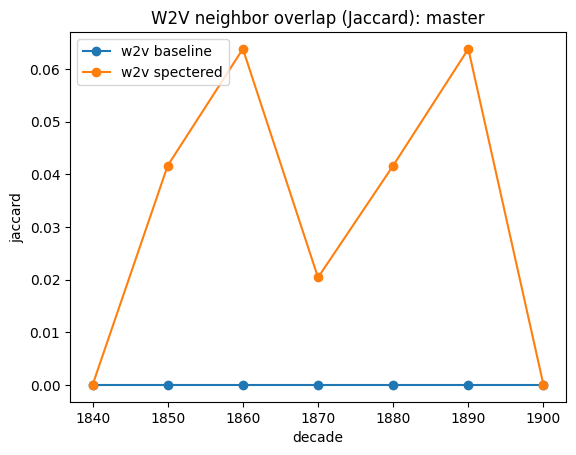

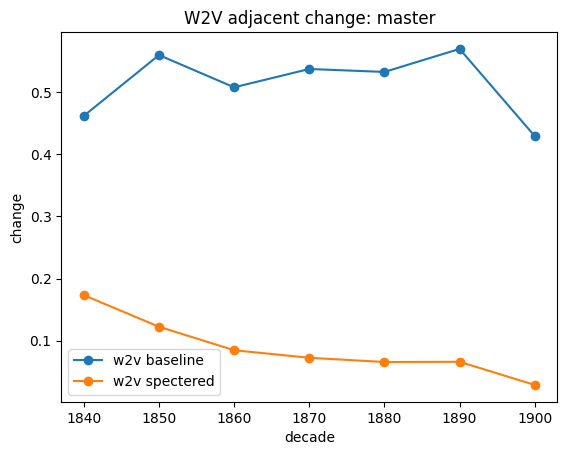


TERM: slave

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"fences, true-born, superabundance, noir, jury, rudiments, labor, inferiors, brotherly, temporal, ownership, freeman"
1,1840,"slaves, extinction, accidental, separation, unfeeling, gainers, cruelties, merited, cell, professes, pounded, dangers"
2,1850,"rag-pole, nojth, rough-shod, kij, jeopardize, jer, abideth, calqrea, celtic, operating, agrarian, editorials"
3,1860,"fpftiti, anid, hmotives, ikdukapolid, scemed, onerous, tranokr, ie-r, andit, flart, asiikr, moralize"
4,1870,"pendent, twar, fadder, boundless, necessitated, somewhar, frien, biz, cullud, unravels, eberybody, tought"
5,1880,"accumulations, degrade, sisted, averments, demurrer, apprehend, enactment, whipping-post, subtlest, half-dollar, codes, inchoate"
6,1890,"sior, zhc, barbee, cui, ffaitbful, confines, tory, mayflower, agents, sugar-cane, transcends, tear-compelling"
7,1900,"sponging, compulsory, worldold, greeks, humbler, child-wise, thirtyseven, multiplies, eras, disinterested, potency, diffidence"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"fences, true-born, superabundance, noir, jury, rudiments, labor, inferiors, brotherly, temporal, ownership, freeman"
1,1840,"torture, extinction, slaves, freeman, poplar-grove, outrages, honorable, oppressions, slaveholder, separation, openly, servitude"
2,1850,"slave-ship, slave-dealer, oppressions, slaveholder, extinction, slave-holders, rag-pole, abolished, celtic, legislating, humane, ill-will"
3,1860,"emancipating, slaveholder, uphold, miscalled, perpetrated, infanticide, fellow-men, murders, carolinians, anid, educate, slave-holder"
4,1870,"tyrants, self-awakened, slaves, law-abiding, liberation, exhort, slave-holding, slave-holder, insufficient, educate, murders, slaveholder"
5,1880,"degrade, liberation, slaves, govern, educate, ordained, slave-holders, assign, fanatics, denounced, violated, attested"
6,1890,"fanatical, fanatics, sanctioned, hypocrites, slaves, repudiate, vindication, anglo-saxon, freeing, adduced, slave-holder, politic"
7,1900,"compulsory, hiring, constitute, intermarriage, educating, abolitionists, converts, multiplies, slave-holding, politic, publicly, pensioners"


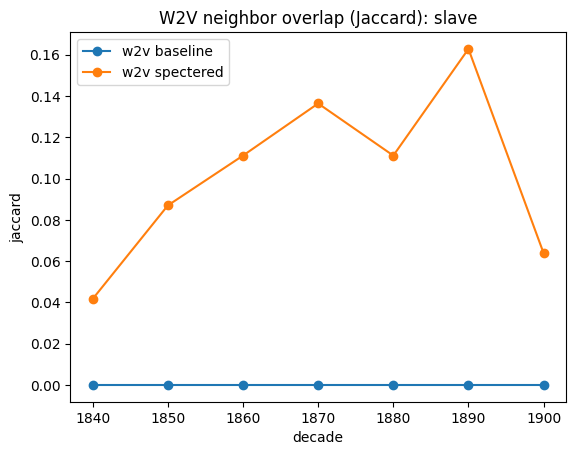

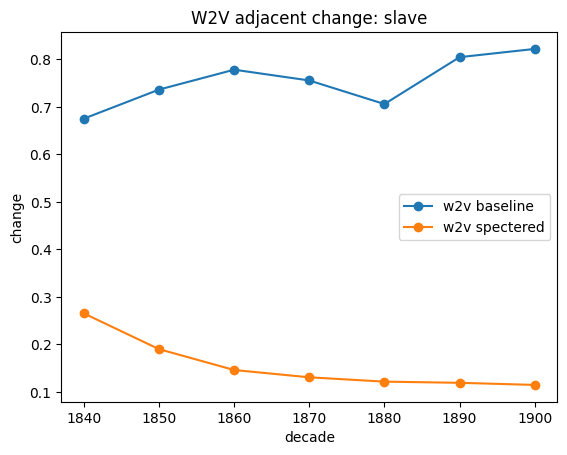


TERM: cotton

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"consenting, sheriffs, vice-president, pocus, vice-presidency, bald-headed, tallow-colored, feeliugs, episcopal, brisker, imitate, teasing"
1,1840,"annually, pods, peas, planted, bales, benefactors, rice, rialto, imported, cottongin, pod, seeds"
2,1850,"home-work, alabam, uncivil, picks, half-yearly, corn-shucking, endicott, codfish, tack, jauntily, ghoul, swill"
3,1860,"export, bales, dons, horse-power, factories, crop, readjusting, slave-ships, puritans, cranium, fabrics, lbs"
4,1870,"breezeless, plomptly, iron-gray, barricade, ashe, cradler, fisk, teamster, pumy, harboring, second-rate, signifying"
5,1880,"aloizg, ern, littleg, bales, diuctum, larceny, weal, spiceries, railroad-track, jerkily, grooves, search-warrant"
6,1890,"pickers, loads, conglomerate, fleece-lined, jobbing, sepia-coloured, crinkle, darkies, hickory-nut, desisting, nonchalence, bowels"
7,1900,"unlighted, recorded, red-clay, vetoed, bales, horny, ginhouse, parenthetically, usher, toughest, roi, sacking"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"consenting, sheriffs, vice-president, pocus, vice-presidency, bald-headed, tallow-colored, feeliugs, episcopal, brisker, imitate, teasing"
1,1840,"rice, annually, rialto, pods, peas, pod, gangs, bales, infants, boot-maker, long-staple, traded"
2,1850,"factories, corporation, pods, hoeing, boarding, crickets, gangs, lard, endicott, tortugas, whips, chair-men"
3,1860,"horse-power, factories, slave-ships, bale, haberdashery, half-suspected, ninety, bales, crop, rice, inhabiting, oxen"
4,1870,"bale, bales, hams, dry-goods, hitting, planting, cooks, oxen, breezeless, queer-looking, condiment, candlesticks"
5,1880,"bales, bottoms, scoured, peeled, sea-island, diuctum, hominy, bulrush, long-handled, aloizg, ern, oxen"
6,1890,"bales, conglomerate, jobbing, loads, sacks, pickers, bowels, yellowish, groceries, jugs, cottonpicking, busybodies"
7,1900,"bales, roi, smokehouse, parenthetically, holstein, bottoms, southampton, stew, cotton-picking, copper, wharves, turnips"


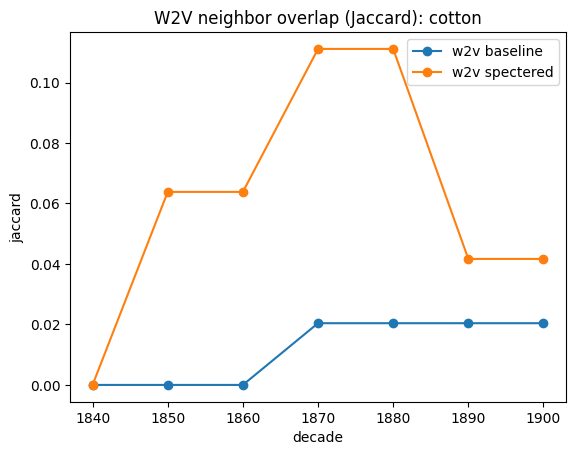

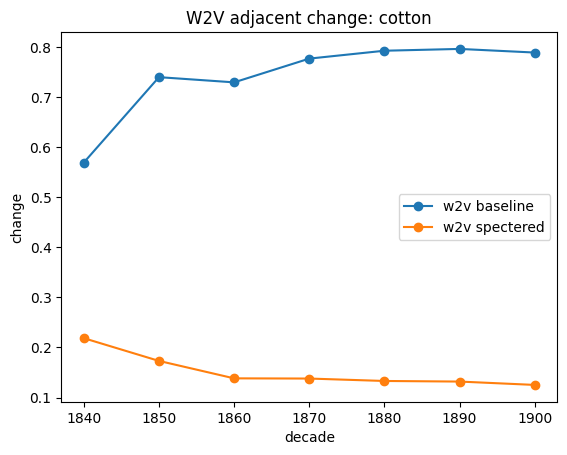


TERM: negro

W2V baseline neighbors (clean)


,decade,neighbors
0,1830,"casion, bery, tan, distory, wuss, unrestrainable, unhesitatingly, complacently, jannet, misshapen, dem, etarnal"
1,1840,"mistresses, duelist, inn, instructs, negroes, presbyterian, eice, inton, auction-store, thereon, extinction, slave-ship"
2,1850,"smut, meliorated, flog, proaching, pennant, cbsely, savior, editorials, highly-scented, hummin, forfeits, palatable"
3,1860,"secessionist, bucksville, clay-eaters, house-keeper, boston-dray, thumb-screw, thunder-storm, negro-quarters, slave-woman, mepherson, amis, cane-fields"
4,1870,"spout, progeny, stable-boys, quitting, yerself, zalea, stalked, pump, prickly, downwards, smart, errand-boy"
5,1880,"rechoes, piscatorial, cornell, befo, nimblest, flips, entry, ferent, carriage-seat, richly-attired, stump-root, georta"
6,1890,"rils, hurrahing, clinton, pro-eminence, agitator, school-teachers, mayors, illhealth, beastly, auctioning, downtrodden, dismissing"
7,1900,"portionately, virtually, folk-lore, inferiority, amalgamation, imperturbable, bondage, satan-forged, educating, race, anglo-saxon, assaulting"



W2V spectered neighbors (clean)


,decade,neighbors
0,1830,"casion, bery, tan, distory, wuss, unrestrainable, unhesitatingly, complacently, jannet, misshapen, dem, etarnal"
1,1840,"emancipating, instructs, negroes, mistresses, avowing, encourages, vesey, auction-store, submitting, extinction, duelist, reunited"
2,1850,"meliorated, negroes, slave-ship, mistresses, cornhill, smut, traders, slave-dealers, productiveness, proaching, frugality, irredeemable"
3,1860,"blacks, abolishing, productiveness, workee, amis, zanguebar, pride-hating, cane-fields, clocks, legree, cornered, surliness"
4,1870,"progeny, jungles, crows, comfortabler, blacks, spout, ethiopian, zalea, bloated, identification, potato, sile"
5,1880,"piscatorial, superstitions, emerging, dialect, self-seeking, flips, georta, corn-shucking, spatter, tinued, dom, cotton-field"
6,1890,"slave-ship, hurrahing, school-teachers, rils, gendeman, beastly, impervious, sisted, regent, hangers-on, ethiopian, tinued"
7,1900,"race, intermarriage, satan-forged, convicts, blacks, criminals, slaveholders, dens, gof, cranium, clother, abolitionists"


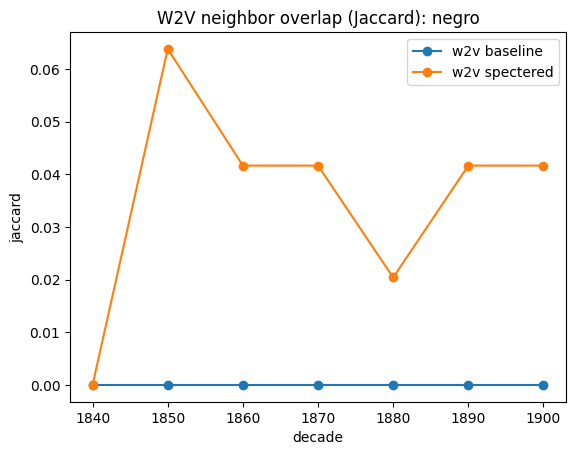

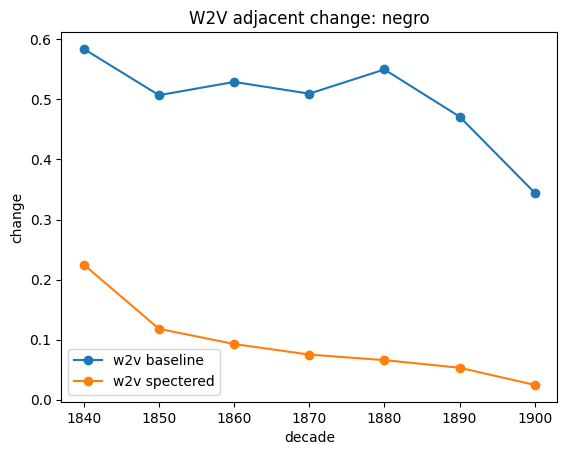

In [ ]:
for term in TARGET_WORDS:
    print("\n" + "="*90)
    print("TERM:", term)

    print("\nW2V baseline neighbors (clean)")
    display(neighbor_trail(term, w2v_aligned, k=75, keep_k=12))

    print("\nW2V spectered neighbors (clean)")
    display(neighbor_trail(term, w2v_spectered, k=75, keep_k=12))

    # Quantitative: neighbor overlap
    df_ov_base = neighbor_overlap(term, w2v_aligned, k=100, keep_k=25)
    df_ov_spec = neighbor_overlap(term, w2v_spectered, k=100, keep_k=25)
    plot_two_series(df_ov_base, df_ov_spec, x="decade", y="jaccard",
                    label_a="w2v baseline", label_b="w2v spectered",
                    title=f"W2V neighbor overlap (Jaccard): {term}")

    # Drift plot
    df_drift_base = adjacent_change(term, w2v_aligned)
    df_drift_spec = adjacent_change(term, w2v_spectered)
    plot_two_series(df_drift_base, df_drift_spec, x="decade", y="change",
                    label_a="w2v baseline", label_b="w2v spectered",
                    title=f"W2V adjacent change: {term}")
